# Imbalance task - Rank Swapping

#### Author: Michał Okoń

In [72]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import logging
from typing import Callable, Optional, Tuple, Union
from sklearn.base import BaseEstimator
from numpy import ndarray
import os
import nbformat
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [73]:
# If this cell does not work try running ``

nb = nbformat.read("Lab1_Michal_Okon.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 278


### Rank-swapping algorithm implementation
In the implementation of the rank-swapping algorithm, I will be swapping the values of the numerical and ordinal features in our code. Moreover, I have added several new aggregated features to better utilize the rank swap algorithm. That is, I will be swapping amount of euros transferred in the transaction and the variables that related to the number of times certain ip/cards/emails have been used.

In [74]:
def rank_swap_custom(df, features_to_swap, swap_range=0.02):
    """
    Rank-swaps the values of the features in the dataframe.
    :param df: dataframe to be swapped
    :param features_to_swap: features to be swapped
    :param swap_range: swap range as a percentage of the dataframe length
    :return: swapped dataframe
    """
    # Select the swap range
    swap_range = int(swap_range * len(df))

    df_swapped = df.reset_index(drop=False)
    for feature in features_to_swap:

        df_swapped = df_swapped.sort_values(by=feature)
        df_swapped = df_swapped.reset_index(drop=True)

        # Swap the values of the feature
        for i in range(len(df)):
            swap_index = random.randint(max(0, i - swap_range), min(i + swap_range, len(df) - 1))
            df_swapped.at[i, feature], df_swapped.at[swap_index, feature] = df_swapped.at[swap_index, feature], \
                df_swapped.at[i, feature]

    df_swapped.set_index('Id', inplace=True, drop=True)
    df_swapped = df_swapped.sort_index()
    return df_swapped

### Preprocessing
Here, I add code to clean the data, engineer new features, encode the features and scale them.

In [75]:

# Function to get all unique country codes
def get_country_codes(df):
    # Combine unique issuer country codes and shopper country codes and get the unique values
    unique_country_codes = pd.Series(
        np.append(df['issuercountrycode'].unique(), df['shoppercountrycode'].unique())).unique()
    return unique_country_codes


# Function to encode data
def encode_data(df):
    # Make a copy of the dataframe to avoid modifying the original
    df = df.copy(deep=True)

    # Declare and fit encoders for labels
    label_encoders = {col: LabelEncoder().fit(df[col]) if col not in ['issuercountrycode',
                                                                      'shoppercountrycode'] else LabelEncoder().fit(
        get_country_codes(df)) for col in
                      ['card_id', 'ip_id', 'issuercountrycode', 'shoppercountrycode', 'txvariantcode', 'currencycode',
                       'shopperinteraction', 'accountcode', 'cardverificationcodesupplied', 'mail_id', 'bin']}

    # Transform the data using the fitted encoders
    for col, encoder in label_encoders.items():
        df[col] = encoder.transform(df[col])

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])

    return df


# Function to one-hot encode specified columns
def one_hot_encode(df, one_hot_columns):
    encoder = OneHotEncoder(sparse=False)
    # Fit the encoder and transform the columns into one-hot encoding
    encoded_cols = encoder.fit_transform(df[one_hot_columns])
    encoded_cols_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names(one_hot_columns), index=df.index)
    # Drop the original columns and replace with the one-hot encoded columns
    df = df.drop(one_hot_columns, axis=1)
    df = pd.concat([df, encoded_cols_df], axis=1)

    return df


# Function to convert an amount in a specific currency to euros
def convert_to_euros(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']])


# Function to clean data
def clean_data(df):
    df = df.copy(deep=True)
    # Clean up data inconsistencies
    df['cardverificationcodesupplied'].fillna(False, inplace=True)
    df['mail_id'].where(~df['mail_id'].str.contains('na', case=False), 'email99999', inplace=True)
    df['cvcresponsecode'].where(df['cvcresponsecode'] <= 2, 3, inplace=True)
    df['issuercountrycode'].fillna('--', inplace=True)
    df['shoppercountrycode'].fillna('--', inplace=True)
    df['amount_eur'] = df.apply(convert_to_euros, axis=1)
    df['accountcode'] = df['accountcode'].str.replace('Account', '')
    df['accountcode'].replace({'UK': 'GB', 'Mexico': 'MX', 'Sweden': 'SE', 'APAC': 'APAC'}, inplace=True)

    return df

In [76]:
def engineer_ordinal_features(df):
    """
    Add new features to the dataframe related to the number of times certain IP, cards, emails have been used.

    Parameters
    ----------
    df : pandas.DataFrame
        Original DataFrame to be modified.

    Returns
    -------
    df : pandas.DataFrame
        Modified DataFrame with additional features.
    """
    # Check if the shopper's country of origin is the same as the issuer country or currency
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode']).astype(int)
    df['currency_equal'] = (df['shoppercountrycode'] == df['currencycode']).astype(int)

    # Check with how many different cards/ips/emails a certain card, ip, email has been used
    df['card_email_count'] = df.groupby('mail_id')['card_id'].transform('count')
    df['card_ip_count'] = df.groupby('ip_id')['card_id'].transform('count')
    df['email_card_count'] = df.groupby('card_id')['mail_id'].transform('count')
    df['ip_card_count'] = df.groupby('card_id')['ip_id'].transform('count')
    df['email_ip_count'] = df.groupby('ip_id')['mail_id'].transform('count')
    df['ip_email_count'] = df.groupby('mail_id')['ip_id'].transform('count')

    # Check how many times a certain card, email, ip, bin has been used
    df['card_count'] = df.groupby('card_id')['card_id'].transform('count')
    df['email_count'] = df.groupby('mail_id')['mail_id'].transform('count')
    df['ip_count'] = df.groupby('ip_id')['ip_id'].transform('count')
    df['bin_count'] = df.groupby('bin')['bin'].transform('count')

    return df

In [77]:



def train_and_plot_classifiers(
        classifier,
        data_quad: Tuple[ndarray, ndarray, ndarray, ndarray],
        cv_func: Optional[Callable] = None
) -> Tuple[ndarray, ndarray, float, BaseEstimator]:
    """
    Train the classifier and plot the ROC curve and confusion matrix.

    Args:
    classifier: The classifier to train.
    data_quad: A tuple containing the train and test data and labels.
    cv_func: A function to perform cross-validation. If None, the classifier is fit directly.

    Returns:
    Tuple containing fpr, tpr, roc_auc, and the trained classifier.
    """
    X_train, X_test, y_train, y_test = data_quad

    if cv_func is None:
        classifier.fit(X_train, y_train)
    else:
        classifier = cv_func(X_train, y_train, classifier, scoring='accuracy', k=10)

    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]

    logging.info(classification_report(y_test, y_pred))
    logging.info(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    return fpr, tpr, roc_auc, classifier


def plot_roc_curves(
        plot_title: str,
        *plot_tuples: Tuple[ndarray, ndarray, str]
) -> None:
    """
    Plot ROC curves for multiple models.

    Args:
    plot_title: The title for the plot.
    plot_tuples: Tuples containing fpr, tpr, and roc_auc for each model.
    """
    plt.clf()

    for fpr, tpr, label in plot_tuples:
        plt.plot(fpr, tpr, label=label)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend()
    plt.show()


In [78]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

# Connect the train and test dataframes
train_data_df['is_train'] = 1
test_data_df['is_train'] = 0
data_df = pd.concat([train_data_df, test_data_df], axis=0, sort=False)

#### The code below may take a while to run.

In [79]:
# Clean and encode the data
cleaned_data_df = clean_data(data_df)
engineered_data_df = engineer_ordinal_features(cleaned_data_df.copy())
transformed_data_df = encode_data(engineered_data_df.copy())

# Split back into the train and test dataframes
transformed_train_data_df = transformed_data_df[transformed_data_df['is_train'] == 1].copy()
transformed_train_data_df.drop(['is_train'], axis=1, inplace=True)
transformed_test_data_df = transformed_data_df[transformed_data_df['is_train'] == 0].copy()
transformed_test_data_df.drop(['is_train'], axis=1, inplace=True)
transformed_test_data_df.drop(['label'], axis=1, inplace=True)

# Perform swapping
df_swapped = rank_swap_custom(transformed_train_data_df.copy(),
                              features_to_swap=["amount_eur", 'card_email_count', 'card_ip_count', 'email_card_count',
                                                'ip_card_count', 'email_ip_count', 'ip_email_count', 'card_count',
                                                'email_count', 'ip_count'], swap_range=0.05)

# Split the data into train and test sets for training purposes
X = transformed_train_data_df.drop(['label'], axis=1)
y = transformed_train_data_df['label']

train_test_pairs = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the swapped data into train and test sets for training purposes
X_swapped = df_swapped.drop(['label'], axis=1)
y_swapped = df_swapped['label']

train_test_pairs_swapped = train_test_split(X_swapped, y_swapped, test_size=0.2, random_state=42)

transformed_train_data_df.head(20)

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,...,card_email_count,card_ip_count,email_card_count,ip_card_count,email_ip_count,ip_email_count,card_count,email_count,ip_count,bin_count
Id,,,,,,,,,,,,,,,,,,,,,
1,0.339744,0.166667,0.904210,0.002275,0.25,0.341935,0.5,1.0,0.333333,0.333333,...,0.000000,0.006438,0.000000,0.000000,0.006438,0.000000,0.000000,0.000000,0.006438,0.066618
2,0.339744,0.250000,0.980688,0.001710,0.25,0.341935,0.5,1.0,0.333333,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065030
3,0.339744,0.166667,0.857088,0.001966,0.25,0.341935,0.5,1.0,0.333333,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083951
4,0.339744,0.666667,0.422943,0.007821,0.25,0.341935,0.0,0.0,0.000000,0.333333,...,0.005935,0.004292,0.017699,0.017699,0.004292,0.005935,0.017699,0.005935,0.004292,0.350754
6,0.339744,0.666667,0.472383,0.002580,0.25,0.341935,0.5,1.0,0.333333,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068735
8,0.339744,0.666667,0.473542,0.001163,0.25,0.341935,0.0,0.0,0.000000,0.333333,...,0.000000,0.002146,0.000000,0.000000,0.002146,0.000000,0.000000,0.000000,0.002146,0.353136
10,0.339744,0.666667,0.269602,0.005113,0.25,0.341935,0.5,1.0,0.333333,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.622122
11,0.339744,0.666667,0.264195,0.003554,0.25,0.341935,0.5,1.0,0.333333,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182522
12,0.339744,0.666667,0.422943,0.002631,0.25,0.341935,0.5,1.0,0.333333,0.333333,...,0.000000,0.004292,0.000000,0.000000,0.004292,0.000000,0.000000,0.000000,0.004292,0.350754


### 3b. Analyse the performance of the classifiers. Explain which method performs best.
From the code below, it is clear that the original data performs slightly better than the swapped variant. However, both methods perform quite bad to the fact that rank-swapping does not solve the problem with class imbalance.

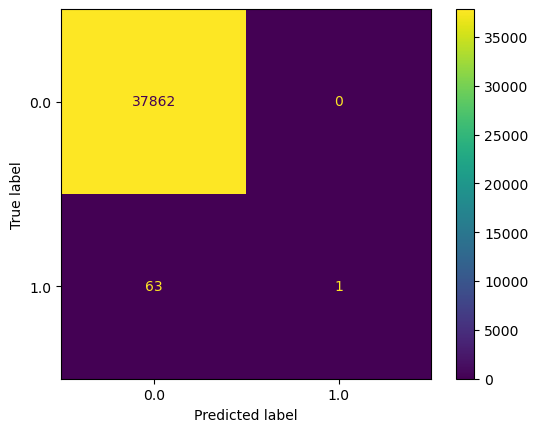

In [80]:
# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1)
knn_fpr, knn_tpr, knn_roc_auc, _ = train_and_plot_classifiers(
    knn_classifier, train_test_pairs
)

C:\Users\micha\anaconda3\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micha\anaconda3\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micha\anaconda3\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


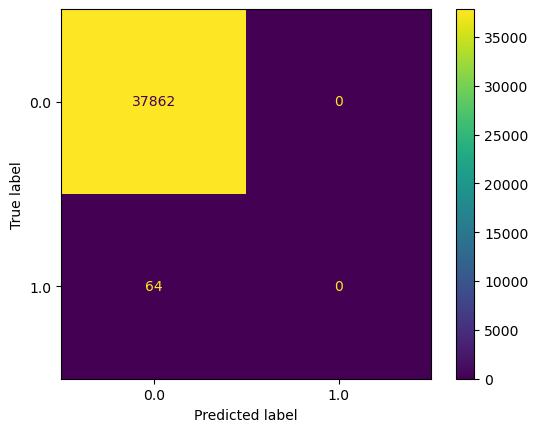

In [81]:
# Logistic regression
logistic_regression_classifier = LogisticRegression(random_state=0)
logistic_regression_fpr, logistic_regression_tpr, logistic_regression_roc_auc, _ = train_and_plot_classifiers(
    logistic_regression_classifier, train_test_pairs
)


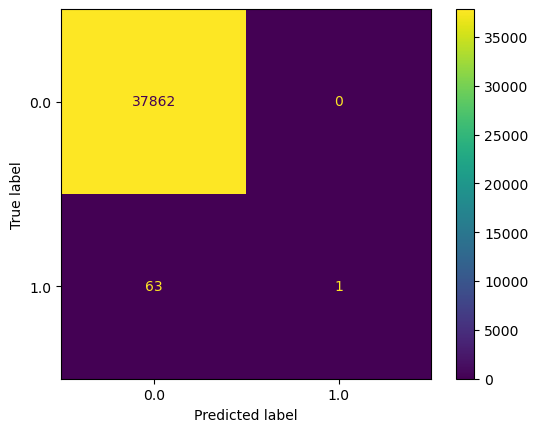

In [82]:
# Random forest
random_forest_classifier = RandomForestClassifier(random_state=0, class_weight='balanced')
random_forest_fpr, random_forest_tpr, random_forest_roc_auc, _ = train_and_plot_classifiers(
    random_forest_classifier, train_test_pairs
)

### Analyzing the performance of different classifiers on the swapped data

C:\Users\micha\anaconda3\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micha\anaconda3\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micha\anaconda3\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


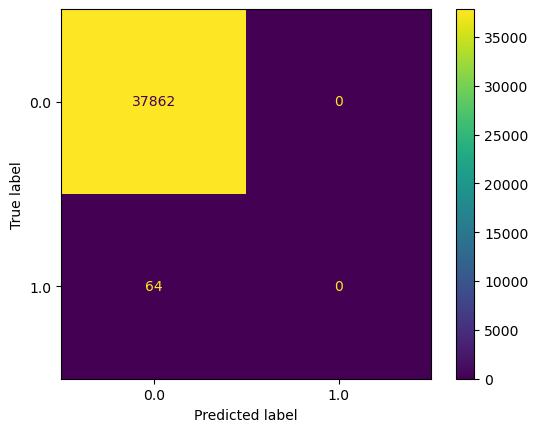

In [83]:
# KNN
knn_fpr_swapped, knn_tpr_swapped, knn_roc_auc_swapped, _ = train_and_plot_classifiers(
    knn_classifier, train_test_pairs_swapped
)

C:\Users\micha\anaconda3\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micha\anaconda3\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micha\anaconda3\envs\new_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


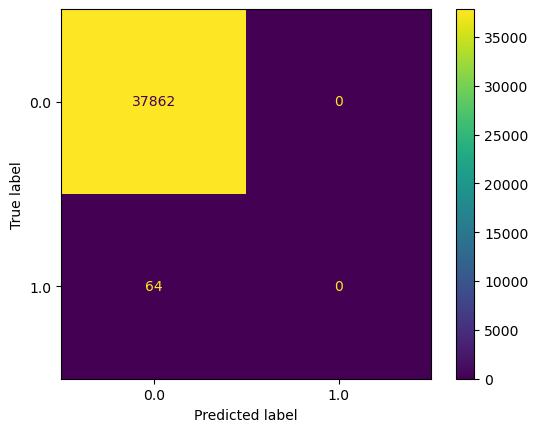

In [84]:
# Logistic regression
logistic_regression_fpr_swapped, logistic_regression_tpr_swapped, logistic_regression_roc_auc_swapped, _ = train_and_plot_classifiers(
    logistic_regression_classifier, train_test_pairs_swapped
)


In [ ]:
# Random forest
random_forest_fpr_swapped, random_forest_tpr_swapped, random_forest_roc_auc_swapped, _ = train_and_plot_classifiers(
    random_forest_classifier, train_test_pairs_swapped)

### Roc curves for different classifiers
#### Original data

In [ ]:
plot_roc_curves("ROC curves for different classifiers",
                (knn_fpr, knn_tpr, f"K Nearest Neighbors (AUC = {knn_roc_auc:.4f})"),
                (logistic_regression_fpr, logistic_regression_tpr,
                 f"Logistic regression (AUC = {logistic_regression_roc_auc:.4f})"),
                (random_forest_fpr, random_forest_tpr, f"Random forest (AUC = {random_forest_roc_auc:.4f})")
                )

#### Swapped data

In [ ]:
plot_roc_curves("ROC curves for different classifiers",
                (knn_fpr_swapped, knn_tpr_swapped, f"K Nearest Neighbors (AUC = {knn_roc_auc_swapped:.4f})"),
                (logistic_regression_fpr_swapped, logistic_regression_tpr_swapped,
                 f"Logistic regression (AUC = {logistic_regression_roc_auc_swapped:.4f})"),
                (random_forest_fpr_swapped, random_forest_tpr_swapped,
                 f"Random forest (AUC = {random_forest_roc_auc_swapped:.4f})")
                )

### Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?
While for the logistic regression both swapped and unswapped data perform similarly, for the random forest classifier and knn classifier the swapped data variant performs worse. One possible explanation here is that, once the data is shuffled, we lose part of the correlation between the features. That is especially true for the data that is still ordinal but consists of just a unique few values. While making a decision on whether to implement the rank-swapping, we need to consider the trade-off between the privacy and the slight decrease of performance.